# PyTorch Implementation 

## Setup

In [1]:
# Standard Library Imports
import os
import time
import tracemalloc

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import transforms

# Scikit-Learn Imports
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# IPython Widgets
from ipywidgets import interact

# Project-Specific Imports
from MiraBest_F import MBFRFull
from FRDEEP import FRDEEPN, FRDEEPF


In [2]:
run = 1
batch_size = 32  
imsize = 150
input_shape = (1, imsize, imsize)
random_state = 42
num_classes = 2

#### Function to show images

In [3]:
def show_image(index):
    img = images[index] / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels[index])
    plt.axis('off')
    plt.colorbar()
    plt.show()

#### Function to save metric to file

In [4]:
def save_metric(metric_name, value):
    file_path = os.path.join(base_path, f'{metric_name}.txt')
    with open(file_path, 'w') as f:
        f.write(str(value))
    print(f"{metric_name.capitalize()}:", value)

## Select Model and Dataset

In [5]:
class ModelDatasetSelector:
    def __init__(self, config):
        self.config = config
        self.batch_size = config['batch_size']
        
        rotate = transforms.RandomRotation([-180, 180])
        totensor = transforms.ToTensor()
        normalise = transforms.Normalize((0.0029,), (0.0341,)) 
        
        self.transforms = transforms.Compose([
            rotate,
            totensor,
            normalise
        ])
        
        self.test_transforms = transforms.Compose([
            totensor
        ])

    def get_dataset(self):
        dataset_map = {
            'mirabest': MBFRFull,
            'frdeep-n': FRDEEPN,
            'frdeep-f': FRDEEPF
        }
        dataset_class = dataset_map.get(self.config['dataset'])
        if not dataset_class:
            raise ValueError(f"Unknown dataset: {self.config['dataset']}")

        train_data = dataset_class(self.config['dataset'], download=True, train=True, transform=self.transforms)
        test_data = dataset_class(self.config['dataset'], download=True, train=False, transform = self.transforms)

        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

        return train_data, test_data, train_loader, test_loader

    def get_model(self):
        model_map = {
            'convxpress': lambda: convXpress(random_state, input_shape, num_classes).to(device),
            'toothless': lambda: toothless_real(random_state, input_shape, num_classes).to(device),
            'mcrgnet': lambda: mcrgNet(random_state, input_shape, num_classes).to(device),
            'first_class': lambda: first_class(random_state, input_shape, num_classes).to(device)
        }
        model_func = model_map.get(self.config['model'])
        if not model_func:
            raise ValueError(f"Unknown model: {self.config['model']}")

        return model_func()
    
    def get_epochs(self):
        # Map model names to their corresponding epoch counts
        epoch_map = {
            'convxpress': 100,
            'toothless': 30,
            'mcrgnet': 60,
            'first_class': 100
        }
        epochs = epoch_map.get(self.config['model'])
        if epochs is None:
            raise ValueError(f"Unknown model: {self.config['model']}")

        return epochs

In [6]:
config = {'dataset': 'mirabest', 
          'model': 'convxpress', 
          'batch_size': 32}

selector = ModelDatasetSelector(config)
train_data, test_data, train_loader, test_loader = selector.get_dataset()

epochs = selector.get_epochs()
print(f"Run {run}")
print(f"Training for {epochs} epochs.")

print(f"Selected dataset: {config['dataset']}")
print(f"Selected model: {config['model']}")
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")

base_path = f"out/pytorch/{config['dataset']}/{config['model']}/run_{run}/"

100%|██████████| 765686/765686 [00:01<00:00, 543006.72it/s]


Run 1
Training for 100 epochs.
Selected dataset: mirabest
Selected model: convxpress
Train loader size: 1069
Test loader size: 153


### Create train and validation sets

In [7]:
train_length = int(0.8*len(train_data))
val_length = len(train_data) - train_length
train, valid = random_split(train_data, [train_length, val_length])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

## Visualize the dataset

In [9]:
#interact(show_image, index=(0,len(images) - 1))

## Create the model

### convXpress

In [10]:
class convXpress(nn.Module):
    def __init__(self, random_state, input_shape, num_classes):
        super(convXpress, self).__init__()
        
        torch.manual_seed(random_state)
                
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride =2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size=2, padding = 1)
        self.dropout_conv = nn.Dropout(0.25)
        
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride =2, padding = 1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding = 1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding = 1)
        
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
        
        self.conv10 = nn.Conv2d(128, 256, kernel_size=3, padding = 1)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, padding = 1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 500)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, num_classes)
        
        # Initialize weights
        self._initialize_weights(random_state)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
    def _initialize_weights(self, random_state):
        torch.manual_seed(random_state)
        # He initialization for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

### toothless

In [11]:
class toothless_real(nn.Module):
    def __init__(self, random_state, input_shape, num_classes): 
        super(toothless_real, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0)
        self.batch1 = nn.BatchNorm2d(96)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=1)
        self.batch2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.batch3 = nn.BatchNorm2d(384)
        
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.batch4 = nn.BatchNorm2d(384)
        
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.batch5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2304, 4096)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(4096, 2)
        
        # Initialize weights
        self._initialize_weights(random_state)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        
        x = F.relu(self.conv4(x))
        x = self.batch4(x)
        
        x = F.relu(self.conv5(x))
        x = self.batch5(x)
        x = self.pool5(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout_fc(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout_fc(x)
        
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    def _initialize_weights(self, random_state):
        torch.manual_seed(random_state)
        # He initialization for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

### mcrgNet

In [12]:
class mcrgNet(nn.Module):
    def __init__(self, random_state, input_shape, num_classes):
        super(mcrgNet, self).__init__()
        torch.manual_seed(random_state)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.dropout_conv = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(800,64)
        self.fc2 = nn.Linear(64,num_classes)
        
        self._initialize_weights(random_state)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv4(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv5(x))
        x = self.dropout_conv(x)
        
        # flatten, dense, dropout, dense
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout_conv(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
    def _initialize_weights(self, random_state):
        torch.manual_seed(random_state)
        # He initialization for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

### firstClass

In [13]:
class first_class(nn.Module):
    def __init__(self, random_state, input_shape, num_classes):
        super(first_class, self).__init__()
        torch.manual_seed(random_state)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=194, kernel_size=3, padding=1)
        self.dropout_conv = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(62856 ,194)
        self.fc2 = nn.Linear(194,num_classes)
        
        self._initialize_weights(random_state)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten, dense, dropout, dense
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout_conv(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
    def _initialize_weights(self, random_state):
        torch.manual_seed(random_state)
        # He initialization for Conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

## Switch to CPU 

In [14]:
device = torch.device('cpu')
print(device)
images = images.to(device)
labels = labels.to(device)

cpu


## Train the model

In [15]:
model = selector.get_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
trainingEpoch_loss = []
validationEpoch_loss = []

In [17]:
# Begin memory usage
tracemalloc.start()

In [18]:
# Begin timing  
start_time = time.time()

In [19]:
for epoch in range(epochs):
    train_loss = []
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()  
        # Forward pass
        outputs = model(images)
        # Find the loss
        loss = criterion(outputs, labels)
        # Calculate the gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Calculate the loss
        train_loss.append(loss.item())
        
    trainingEpoch_loss.append(np.mean(train_loss))
    
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            valid_loss.append(loss.item())
        
        validationEpoch_loss.append(np.mean(valid_loss)) 
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {trainingEpoch_loss[epoch]} \t\t Validation Loss: {validationEpoch_loss[epoch]}')

print('Finished Training')

/home/madhia/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 		 Training Loss: 0.7401541780542444 		 Validation Loss: 0.709516167640686
Epoch 2 		 Training Loss: 0.7533629580780312 		 Validation Loss: 0.7034099357468742
Epoch 3 		 Training Loss: 0.6937600881965073 		 Validation Loss: 0.7034232786723545
Epoch 4 		 Training Loss: 0.6982032943654943 		 Validation Loss: 0.6922821572848729
Epoch 5 		 Training Loss: 0.6909716040999802 		 Validation Loss: 0.6894170301301139
Epoch 6 		 Training Loss: 0.6897983551025391 		 Validation Loss: 0.688198276928493
Epoch 7 		 Training Loss: 0.692187887650949 		 Validation Loss: 0.6855472837175641
Epoch 8 		 Training Loss: 0.6886712025713038 		 Validation Loss: 0.6943187202726092
Epoch 9 		 Training Loss: 0.689254484794758 		 Validation Loss: 0.6818764209747314
Epoch 10 		 Training Loss: 0.6818507026743006 		 Validation Loss: 0.6813475745064872
Epoch 11 		 Training Loss: 0.6828115692845097 		 Validation Loss: 0.6757916126932416
Epoch 12 		 Training Loss: 0.6771102437266597 		 Validation Loss: 0.6685831461

### Training time

In [21]:
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time = round(elapsed_time, 2)
print(f"The training took {elapsed_time} seconds.")

save_metric('train_time', elapsed_time)

The training took 1171.22 seconds.
Train_time: 1171.22


### Memory usage

In [22]:
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak memory usage: {peak / 10**6:.2f} MB")

peak_memory = peak / 10**6  # Convert to MB

save_metric('mem_use', peak)

Current memory usage: 6.21 MB
Peak memory usage: 8.05 MB
Mem_use: 8050576


### Save the model 

In [23]:
PATH = f"out/pytorch/{config['dataset']}/{config['model']}/run_{run}/model.pth"
torch.save(model.state_dict(), PATH)

## Predict and Results

In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

model.load_state_dict(torch.load(PATH))

all_predictions = []
all_labels = []

In [ ]:
# time 
start_time = time.time()

In [25]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

### Classification time

In [26]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"The predictions took {elapsed_time} seconds.")
elapsed_time = round(elapsed_time, 2)

save_metric('class_time', elapsed_time)

The predictions took 1182.6372938156128 seconds.
Class_time: 1182.64


### Accuracy

In [27]:
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = 100 * np.sum(all_predictions == all_labels) / len(all_labels)
print('Accuracy: ', accuracy)
accuracy = round(accuracy, 2)

save_metric('accuracy', accuracy)

Accuracy:  82.3529411764706
Accuracy: 82.35


### F1 Score

In [31]:
f1 = 100 * f1_score(all_labels, all_predictions, average='weighted')
print('F1 Score: ', f1)
f1 = round(f1, 2)

save_metric('f1', f1)

F1 Score:  82.31508657347703
F1: 82.32


### Confusion matrix

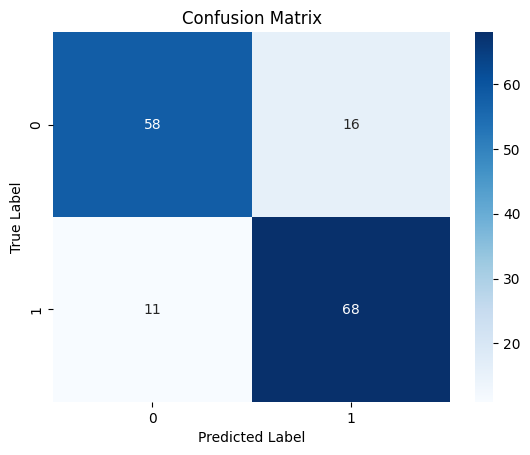

In [28]:
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(base_path, "confusion_matrix.svg"))
plt.show()

## Visualize Predictions

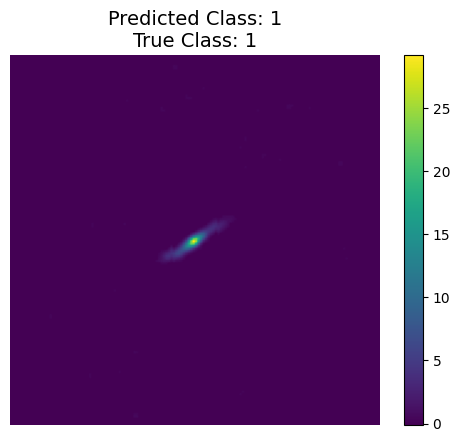

In [29]:
image = images[0]
img = image / 2 + 0.5     # unnormalize
image = image.cpu().numpy()
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f"Predicted Class: {all_predictions[0]}\nTrue Class: {all_labels[0]}", fontsize=14)
plt.axis('off')
plt.colorbar()
plt.show()

## Training Results 

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(range(epochs), trainingEpoch_loss, label='Training Loss')
plt.plot(range(epochs), validationEpoch_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss in PyTorch')
plt.savefig(os.path.join(base_path, "train.svg"))
plt.close()